In [32]:
import shutil
import pathlib
import argparse
import yaml
import timm
import tqdm

import torch
import pandas as pd
import numpy as np
import itertools

import constants as const
import dataset
import fastflow

In [33]:
def parse_args(arg_list: list):
    """ArgumentParseインスタンスを作成し，コマンドライン引数を読み込む．
    Returns:
        args
    """
    parser = argparse.ArgumentParser(description="Train FastFlow_org on MVTec-AD dataset")
    parser.add_argument(
        "-cfg", "--config", type=str, required=True, help="path to config file"
    )
    parser.add_argument('--name', type=str, required=True, help='dataset name')
    parser.add_argument("--data", type=str, required=True, help="path to dataset folder")
    parser.add_argument(
        "-cat",
        "--category",
        type=str,
        required=True,
        help="category name in dataset. If 'all' was specified, train FastFlow by using all OK_Clip data",
    )
    parser.add_argument('--valid', type=str, help='validation category')
    parser.add_argument('--color', type=str, choices=['rgb', 'gray'])
    parser.add_argument('--shuffle', action='store_true', help='shuffle batch')
    parser.add_argument('-p', '--patchsize', type=int, help='patch size. By default, patch separation will not do')
    parser.add_argument('--random', action='store_true', help='random patch sampling')
    parser.add_argument('--mask', action='store_true', help='target mask')
    parser.add_argument("--eval", action="store_true", help="run eval only")
    parser.add_argument("--post", action='store_true', help='run postprocessing only')
    parser.add_argument(
        "-ckpt", "--checkpoint", type=str, help="path to load checkpoint"
    )
    parser.add_argument("--heatmap", action='store_true', help='saving heatmap on test images')
    parser.add_argument('-t', '--threshold', type=float, help='threshold')

    # 引数のチェック
    dataset_list = ['mvtec', 'jelly', 'package']
    args = parser.parse_args(arg_list)

    assert args.name in dataset_list, f'利用可能なデータセットは{dataset_list}です．'

    if args.name == 'mvtec':
        assert args.category in const.MVTEC_CATEGORIES, f'MVTecにおいて利用可能なクラスは{const.MVTEC_CATEGORIES}です'
    if args.name == 'jelly':
        assert args.category in const.JELLY_CATEGORIES, f'Jellyにおいて利用可能なクラスは{const.JELLY_CATEGORIES}です'

    return args

In [35]:
args_list = [
    '--config', 'C:\\Users\s2231\PycharmProjects\FastFlow\Fast_flow\FastFlow\configs\\deit.yaml',
    '--name',
    'package',
    '--data',
    'C:\\Users\s2231\PycharmProjects\FastFlow\Fast_flow\FastFlow\data\package_square',
    '-cat',
    'cut',
    '--valid',
    'cut'
]
args = parse_args(args_list)
with open(args.config, 'r') as yaml_file:
    config = yaml.safe_load(yaml_file)

In [36]:
# backboneのメタ情報を読み込み，モデルをビルド
model = fastflow.build_model(config, args)
optimizer = fastflow.build_optimizer(model)

Total model Param#: 118.297492[MB]


In [37]:
# instantiate dataloader and model
train_dataloader = dataset.build_train_data_loader(args, config)
test_dataloader = dataset.build_test_data_loader(args, config)

In [50]:
# instantiate pretrained model
backbone_name = const.BACKBONE_DEIT
backbone = timm.create_model(backbone_name, pretrained=True, num_classes=0)
backbone.eval()

VisionTransformerDistilled(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, 

In [61]:
def get_embedding(model: torch.nn.Module, batch: torch.Tensor) -> torch.Tensor:
    with torch.no_grad():
        out = model(batch)
    # out = torch.nn.AvgPool2d(kernel_size=out.shape[-2:])(out)
    # out = out.view(*out.shape[:2])
    return out.cpu().detach()

In [62]:
normal_list = []
backbone = backbone.cuda()
for batch in tqdm.tqdm(train_dataloader):
    batch = batch.cuda()
    outputs = get_embedding(backbone, batch)
    normal_list.append(outputs)

100%|██████████| 405/405 [01:01<00:00,  6.60it/s]


In [63]:
normal_list[0].shape

torch.Size([4, 768])

In [67]:
# -> (num_of_normal_samples, B, C)
normal_embed = torch.stack(normal_list, dim=0).cpu().detach().numpy()
normal_embed.shape

(405, 4, 768)

## K-meansのサンプル

In [66]:
class KMeans:
    def __init__(self, n_clusters, max_iter=1000, random_seed=0):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = np.random.RandomState(random_seed)

    # X.shape: (N, D)
    def fit(self, X):
        # initialization
        cycle = itertools.cycle(range(self.n_clusters))
        self.labels_ = np.fromiter(itertools.islice(cycle, X.shape[0]), dtype=np.int)
        self.random_state.shuffle(self.labels_)
        labels_prev = np.zeros(X.shape[0])
        count = 0
        self.cluster_centers_ = np.zeros((self.n_clusters, X.shape[1]))

        while (not (self.labels_ == labels_prev).all() and count < self.max_iter):
            for i in tqdm.tqdm(range(self.n_clusters)):
                XX = X[self.labels_ == i, :]
                print(XX.shape)
                self.cluster_centers_[i, :] = XX.mean(axis=0)
            dist = ((X[..., np.newaxis] - self.cluster_centers_.T[np.newaxis, ...]) ** 2).sum(axis=1)
            labels_prev = self.labels_
            self.labels_ = dist.argmin(axis = 1)
            count += 1

    def predict(self, X):
        dist = ((X[:, :, np.newaxis] - self.cluster_centers_.T[np.newaxis, ...]) ** 2).sum(axis = 1)
        labels = dist.argmin(axis = 1)
        return labels

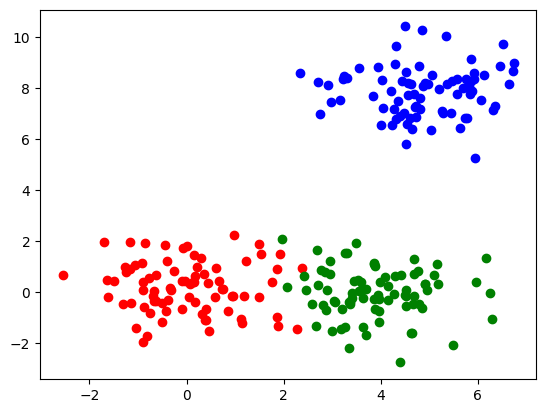

In [31]:
import matplotlib.pyplot as plt
np.random.seed(0)
points1 = np.random.randn(80, 2)  # default cluster
points2 = np.random.randn(80, 2) + np.array([4,0])  # translated_x
points3 = np.random.randn(80, 2) + np.array([5,8])  # translated_x_and_y

points = np.r_[points1, points2, points3]

color = ['r', 'g', 'b']
for i in range(3):
    p = points[80*i:80*(i+1)]
    plt.scatter(p[:, 0], p[:, 1], color = color[i])
plt.show()

In [32]:
np.random.shuffle(points)

model = KMeans(3)
model.fit(points)

print(model.labels_)

C:\Users\s2231\AppData\Local\Temp\ipykernel_76124\1340154803.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.labels_ = np.fromiter(itertools.islice(cycle, X.shape[0]), dtype=np.int)
100%|██████████| 3/3 [00:00<?, ?it/s]


(80, 2)
(80, 2)
(80, 2)


100%|██████████| 3/3 [00:00<?, ?it/s]


(78, 2)
(82, 2)
(80, 2)


100%|██████████| 3/3 [00:00<?, ?it/s]

(77, 2)
(83, 2)
(80, 2)
[1 0 2 1 0 0 2 0 1 2 0 0 2 0 2 2 0 0 2 1 2 0 1 2 0 1 2 1 0 1 0 0 0 2 0 2 0
 1 1 0 0 0 0 1 2 0 0 0 2 1 0 2 1 0 2 0 2 1 1 1 1 1 0 2 0 2 2 0 0 0 0 0 2 0
 2 2 2 1 0 2 1 2 0 0 2 0 1 2 1 1 1 2 2 2 1 2 2 2 1 2 1 0 0 0 0 0 2 0 1 0 1
 2 0 1 1 0 1 2 1 1 1 2 2 1 2 1 0 1 1 2 0 1 0 1 1 1 0 2 1 0 0 1 2 2 2 1 0 0
 0 2 2 2 0 0 1 2 0 2 2 2 1 2 2 2 2 2 1 1 0 1 2 1 1 2 0 1 1 1 1 0 2 1 0 1 1
 2 1 2 2 2 1 2 0 1 2 2 2 0 0 0 0 1 1 2 1 1 1 2 2 0 0 1 1 2 0 0 1 0 1 1 2 1
 0 1 2 1 0 1 2 2 1 1 2 1 2 1 0 1 1 2]


In [37]:
for i in range(3):
    p = points[model.labels_ == i, :]
    plt.scatter(p[:, 0], p[:, 1], color = color[i])
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 240 but corresponding boolean dimension is 1620

## K-meansによる正常画像のクラスタリング

In [102]:
normal_embed.shape

(405, 4, 512)

In [68]:
normal_embed = normal_embed.reshape(normal_embed.shape[0] * normal_embed.shape[1], normal_embed.shape[2])
normal_embed.shape

(1620, 768)

In [69]:
K = 4
model = KMeans(K)
model.fit(normal_embed)

C:\Users\s2231\AppData\Local\Temp\ipykernel_69372\1340154803.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.labels_ = np.fromiter(itertools.islice(cycle, X.shape[0]), dtype=np.int)
100%|██████████| 4/4 [00:00<00:00, 495.75it/s]


(405, 768)
(405, 768)
(405, 768)
(405, 768)


100%|██████████| 4/4 [00:00<?, ?it/s]


(282, 768)
(507, 768)
(288, 768)
(543, 768)


100%|██████████| 4/4 [00:00<00:00, 497.44it/s]


(322, 768)
(469, 768)
(375, 768)
(454, 768)


100%|██████████| 4/4 [00:00<00:00, 498.22it/s]


(322, 768)
(452, 768)
(420, 768)
(426, 768)


100%|██████████| 4/4 [00:00<?, ?it/s]


(318, 768)
(449, 768)
(443, 768)
(410, 768)


100%|██████████| 4/4 [00:00<00:00, 498.14it/s]


(316, 768)
(451, 768)
(457, 768)
(396, 768)


100%|██████████| 4/4 [00:00<?, ?it/s]


(315, 768)
(452, 768)
(464, 768)
(389, 768)


100%|██████████| 4/4 [00:00<00:00, 496.18it/s]


(315, 768)
(452, 768)
(468, 768)
(385, 768)


100%|██████████| 4/4 [00:00<00:00, 256.04it/s]


(315, 768)
(452, 768)
(472, 768)
(381, 768)


100%|██████████| 4/4 [00:00<?, ?it/s]


(314, 768)
(452, 768)
(473, 768)
(381, 768)


100%|██████████| 4/4 [00:00<?, ?it/s]

(313, 768)
(452, 768)
(473, 768)
(382, 768)


In [70]:
model.labels_[:10]

array([1, 3, 3, 0, 2, 3, 2, 2, 2, 3], dtype=int64)

In [71]:
files = train_dataloader.dataset.image_files
file_names = np.array([file.stem for file in files])
file_names

array(['1_Cam1_000597', '2_Cam1_000396', '2_Cam1_000666', ...,
       '1_Cam1_000052', '1_Cam1_000229', '2_Cam1_000691'], dtype='<U13')

In [72]:
img_list = np.array(train_dataloader.dataset.image_files)

In [73]:
index = np.where(model.labels_ == 1)[0]
index

array([   0,   10,   11,   22,   26,   31,   33,   34,   36,   37,   41,
         42,   48,   49,   56,   57,   60,   70,   71,   78,   80,   86,
         93,   94,   96,   98,  102,  103,  105,  108,  110,  114,  116,
        118,  121,  122,  129,  130,  131,  133,  135,  140,  142,  143,
        146,  148,  152,  158,  160,  173,  174,  182,  184,  185,  189,
        192,  194,  196,  201,  204,  206,  211,  212,  214,  220,  221,
        227,  231,  238,  239,  240,  244,  246,  251,  252,  257,  265,
        273,  276,  285,  286,  288,  290,  294,  303,  307,  308,  309,
        310,  312,  317,  321,  322,  324,  327,  328,  330,  334,  337,
        338,  340,  341,  342,  344,  345,  346,  349,  355,  360,  361,
        366,  368,  369,  375,  376,  377,  378,  379,  380,  384,  385,
        386,  387,  396,  404,  411,  418,  422,  425,  427,  429,  432,
        433,  438,  442,  443,  444,  455,  456,  459,  480,  484,  495,
        496,  500,  507,  508,  509,  512,  518,  5

In [74]:
img_list[index]

array([WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/1_Cam1_000597.jpg'),
       WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/1_Cam1_000200.jpg'),
       WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/1_Cam1_000576.jpg'),
       WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/2_Cam1_000231.jpg'),
       WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/2_Cam1_000997.jpg'),
       WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/2_Cam1_000539.jpg'),
       WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/1_Cam1_000029.jpg'),
       WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFl

In [75]:
train_dataloader.dataset.image_files

[WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/1_Cam1_000597.jpg'),
 WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/2_Cam1_000396.jpg'),
 WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/2_Cam1_000666.jpg'),
 WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/2_Cam1_000578.jpg'),
 WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/2_Cam1_000785.jpg'),
 WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/2_Cam1_000361.jpg'),
 WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/2_Cam1_000445.jpg'),
 WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/2_Cam1_000019

In [76]:
data_dir = pathlib.Path(args.data).parent
cluster_dir = data_dir / 'clusters_deit'
cluster_dir.mkdir(exist_ok=True)

In [77]:
for i in range(K):
    subdir = cluster_dir / f'cluster_{i}'
    subdir.mkdir(exist_ok=True)

In [78]:
img_list = np.array(train_dataloader.dataset.image_files)
img_file = img_list[0]
subdir / '/'.join(img_file.parts[-3:])

WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/clusters_deit/cluster_3/cut/OK_Clip/1_Cam1_000597.jpg')

In [79]:
# Save each cluster image
img_list = np.array(train_dataloader.dataset.image_files)
for i in range(K):
    subdir = cluster_dir / f'cluster_{i}'
    index = np.where(model.labels_ == i)[0]
    img_files = list(img_list[index])
    for src_file in img_files:
        src_name = '/'.join(src_file.parts[-3:])
        dst = subdir / src_name
        dst.parent.mkdir(exist_ok=True, parents=True)
        shutil.copy(src_file, dst)

In [80]:
test_files = test_dataloader.dataset.image_files
test_dir = cluster_dir / 'test'

In [81]:
# save test file at cluster directory
for test_file in test_files:
    src_name = '/'.join(test_file.parts[-3:])
    dst = test_dir / src_name
    dst.parent.mkdir(exist_ok=True, parents=True)
    shutil.copy(test_file, dst)

In [82]:
# save K_means model
pd.to_pickle(model, cluster_dir / 'k_means.pkl')

In [83]:
# load K_means Model
k_means = pd.read_pickle(cluster_dir / 'k_means.pkl')

batch = next(iter(train_dataloader))
batch = batch.cuda()
backbone = backbone.cuda()
outputs = get_embedding(backbone, batch)
labels = k_means.predict(outputs)
labels

tensor([1, 3, 3, 0])

In [84]:
from torchvision import transforms
from PIL import Image
from ast import literal_eval

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, root, input_size: str):
        input_size = literal_eval(input_size)
        self.image_transform = transforms.Compose(
            [
                transforms.Resize(input_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )
        data_dir = pathlib.Path(root)
        normal_list = list(data_dir.glob('*/OK_Clip/*.jpg'))
        anomal_list = list(data_dir.glob('*/NG_Clip/*.jpg'))

        self.image_files = normal_list + anomal_list
        self.labels = len(normal_list) * [0] + len(anomal_list) * [1]

    def __getitem__(self, index):
        image_file = self.image_files[index]
        image = Image.open(image_file)
        image = self.image_transform(image)

        return image, self.labels[index]

    def __len__(self):
        return len(self.image_files)

def build_test_dataloader(root: str, input_size: int):
    test_dataset = TestDataset(
        root=root,
        input_size=input_size
    )
    return torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=0,
        drop_last=False
    )

In [85]:
input_size = config['input_size']
test_dataloader = build_test_dataloader(test_dir, input_size)

In [109]:
ckpt_dir_0 = 'C:\\Users\s2231\PycharmProjects\FastFlow\Fast_flow\FastFlow\\results\cluster_0\cut\\fastflow\\2023-01-23-16-25-15\ckpt\\1.pt'
ckpt_dir_1 = 'C:\\Users\s2231\PycharmProjects\FastFlow\Fast_flow\FastFlow\\results\cluster_1\cut\\fastflow\\2023-01-23-16-27-56\ckpt\\1.pt'
ckpt_dir_2 = 'C:\\Users\s2231\PycharmProjects\FastFlow\Fast_flow\FastFlow\\results\cluster_2\cut\\fastflow\\2023-01-23-16-31-06\ckpt\\1.pt'
ckpt_dir_3 = 'C:\\Users\s2231\PycharmProjects\FastFlow\Fast_flow\FastFlow\\results\cluster_3\cut\\fastflow\\2023-01-23-16-34-24\ckpt\\1.pt'

ckpt_dir_list = [ckpt_dir_0, ckpt_dir_1, ckpt_dir_2, ckpt_dir_3]

In [110]:
args_list = [
    '--config', 'C:\\Users\s2231\PycharmProjects\FastFlow\Fast_flow\FastFlow\configs\\deit.yaml',
    '--name',
    'package',
    '--data',
    'C:\\Users\s2231\PycharmProjects\FastFlow\Fast_flow\FastFlow\data\package_square',
    '-cat',
    'cut',
    '--valid',
    'cut'
]
args = parse_args(args_list)
with open(args.config, 'r') as yaml_file:
    config = yaml.safe_load(yaml_file)

In [111]:
# load flow models
K = 4
result_dir = pathlib.Path('C:\\Users\s2231\PycharmProjects\FastFlow\Fast_flow\FastFlow\\results')
model_list = []

for i in range(K):
    ckpt_dir = ckpt_dir_list[i]
    model = fastflow.build_model(config, args)
    checkpoint = torch.load(ckpt_dir)
    model.load_state_dict(checkpoint["model_state_dict"])
    model = model.cuda()
    model.eval()
    model_list.append(model)

Total model Param#: 118.297492[MB]
Total model Param#: 118.297492[MB]
Total model Param#: 118.297492[MB]
Total model Param#: 118.297492[MB]


In [112]:
from sklearn import metrics
from ignite.contrib.metrics import ROC_AUC

batch_size = const.BATCH_SIZE
input_size = literal_eval(config['input_size'])
backbone = backbone.cuda()
auroc_metric = ROC_AUC()

score_list = []
target_list = []

for batch, target in tqdm.tqdm(test_dataloader):
    batch = batch.cuda()

    batch_embed = get_embedding(backbone, batch)
    label_batch = k_means.predict(batch_embed)
    output_list = []
    for i in range(batch.shape[0]):
        with torch.no_grad():
            ret = model_list[label_batch[i]](torch.unsqueeze(batch[i], dim=0))
        output = ret['anomaly_map'].cpu().detach()
        output_list.append(output)
    outputs = torch.stack(output_list, dim=0).view(batch.shape[0], *input_size)
    score = torch.mean(outputs, dim=[1, 2])
    auroc_metric.update((score, target))
    score_list.append(score)
    target_list.append(target)

100%|██████████| 341/341 [00:25<00:00, 13.22it/s]


In [113]:
# 予測性能を評価する．
# 全体の予測結果を集約する．predsは正常確率に負を掛けたもののリストであるため，異常度(scores)に変換する．
preds = torch.concat(score_list, dim=0).cpu().numpy()
targets = torch.concat(target_list, dim=0).cpu().numpy()
scores = 1. + preds

# TPR, FPR, しきい値の計算
fpr_list, tpr_list, thresholds = metrics.roc_curve(targets, scores)
best_thresh_idx = np.argmax(tpr_list - fpr_list)  # TPR - FPRが最大になるようなしきい値が最良
best_threshold = thresholds[best_thresh_idx]

fpr, tpr = fpr_list[best_thresh_idx], tpr_list[best_thresh_idx]
preds_sparse = np.where(scores > best_threshold, 1, 0)  # そのしきい値を用いて異常・正常を分類

# 異常・正常サンプルのスコアを横軸にとるヒストグラムを作成
normal_idx = np.where(targets == 0)
anomaly_idx = np.where(targets == 1)
normal_scores = scores[normal_idx]
anomaly_scores = scores[anomaly_idx]

# 混同行列，AUCの計算
cm = metrics.confusion_matrix(targets, preds_sparse)
auroc = auroc_metric.compute()
auroc

0.5759489302967564